# Marketing Analytics

## Client: E-commerce business

## Project goals: 
1. Develop unique customer segments using RFM (recency, frequency, monetary value) analysis to optimize marketing strategy, increase profits & decrease customer churn.
2. Define product categories
3. Examined how unique customer segments spend per product category to identify upselling & cross-selling opportunities.

## Data available:
~500K rows & 8 columns

**1. Data Preparation**

**2. Exploring the content of variables**

   - 2.1 Countries
   - 2.2 Customers and products
       * 2.2.1 Cancelling orders
       * 2.2.2 StockCode
       * 2.2.3 Basket price

**3.Product segmentation using clustering**

   - 3.1 Product description 
   - 3.2 Defining product categories 
       * 3.2.1 Data encoding
       * 3.2.2 Clusters of products
       * 3.2.3 Characterizing the content of clusters
   - 3.3 Top 20 products for product clusters
   
**4. Customer segmentation using clustering**

   - 4.1 Grouping products 
       
       * 4.1.2 Grouping orders 
   - 4.2 Creating customer categories
       * 4.2.1 Data enconding
       * 4.2.2 Creating categories

**5. RFM analysis**

    - 5.1 RMF on the customer level
    - 5.1 RMF on the cluster level
    
**6. Final remarks - Summary**

_____

## 1. Data preparation

As a first step, I load all the modules that will be used in this notebook:

In [ ]:
#need to install these libraries the first time you run the notebook
# %pip install --user -U nltk
# %conda install -c conda-forge wordcloud
# %conda install -c plotly plotly
# %pip install pandas-profiling

In [ ]:
#%conda update -n base -c defaults conda

In [1]:
import pandas as pd
from datetime import datetime


import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.cm as cm
import itertools
import pandas_profiling
import plotly.graph_objs as go

from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
from datetime import datetime
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/markouskokovic/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/markouskokovic/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

## Import the data & basic info

In [4]:
# import data
data = pd.read_csv('/Users/markouskokovic/Desktop/USC/Fall 2020/DSO 528/data.csv',encoding="ISO-8859-1",
                         dtype={'CustomerID': str,'InvoiceID': str})

In [5]:
data.head()

InvoiceNo StockCode                          Description  Quantity   InvoiceDate  UnitPrice CustomerID         Country
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6  12/1/10 8:26       2.55      17850  United Kingdom
1    536365     71053                  WHITE METAL LANTERN         6  12/1/10 8:26       3.39      17850  United Kingdom
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8  12/1/10 8:26       2.75      17850  United Kingdom
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6  12/1/10 8:26       3.39      17850  United Kingdom
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6  12/1/10 8:26       3.39      17850  United Kingdom

In [6]:
# info

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


In [7]:
# change InvoiceDate col to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [8]:
# size
data.shape

(541909, 8)

* We have almost 550K rows and 8 columns

In [9]:
# check for null values

data.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [10]:
### Let's just see how rows with no customerID look like

data_no_cust_id = data.loc[data['CustomerID'].isna()]

In [11]:
data_no_cust_id.head()

InvoiceNo StockCode                      Description  Quantity         InvoiceDate  UnitPrice CustomerID         Country
622     536414     22139                              NaN        56 2010-12-01 11:52:00       0.00        NaN  United Kingdom
1443    536544     21773  DECORATIVE ROSE BATHROOM BOTTLE         1 2010-12-01 14:32:00       2.51        NaN  United Kingdom
1444    536544     21774  DECORATIVE CATS BATHROOM BOTTLE         2 2010-12-01 14:32:00       2.51        NaN  United Kingdom
1445    536544     21786               POLKADOT RAIN HAT          4 2010-12-01 14:32:00       0.85        NaN  United Kingdom
1446    536544     21787            RAIN PONCHO RETROSPOT         2 2010-12-01 14:32:00       1.66        NaN  United Kingdom

- Since one of our goal is to develop unique customer segments, it is crucial to have customerID for further analysis, therefore we will drop all rows that have no value in customerID column

In [12]:
# drop rows with no custumerID

data.dropna(axis = 0, subset = ['CustomerID'], inplace = True)

In [13]:
# check again for null values

data.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [15]:
# check with how much data we are working with now

data.shape

(406829, 8)

In [17]:
# check for duplicates 
print(f'Number of duplicates: {data.duplicated().sum()}')

Number of duplicates: 5225


In [28]:
print(f'Percentage of duplicate entries fro the total number of entries: {round((data.duplicated().sum() / data.shape[0] * 100), 2)} %')

print('\n')
      
print('Since just over 1% of entries are duplicates we will go ahead and delete them. It remains to be seen what might be the cause of duplicates')

Percentage of duplicate entries fro the total number of entries: 1.28 %


Since just over 1% of entries are duplicates we will go ahead and delete them. It remains to be seen what might be the cause of duplicates


In [29]:
# drop duplicates

data.drop_duplicates(inplace = True)

___
## 2. Exploring the content of fields

This dataframe contains 8 fields that correspond to: 

**InvoiceNo**: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.  <br>
**StockCode**: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. <br>
**Description**: Product (item) name. Nominal. <br>
**Quantity**: The quantities of each product (item) per transaction. Numeric.	<br>
**InvoiceDate**: Invice Date and time. Numeric, the day and time when each transaction was generated. <br>
**UnitPrice**: Unit price. Numeric, Product price per unit in sterling. <br>
**CustomerID**: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. <br>
**Country**: Country name. Nominal, the name of the country where each customer resides.<br>

___
### 2.1 Countries

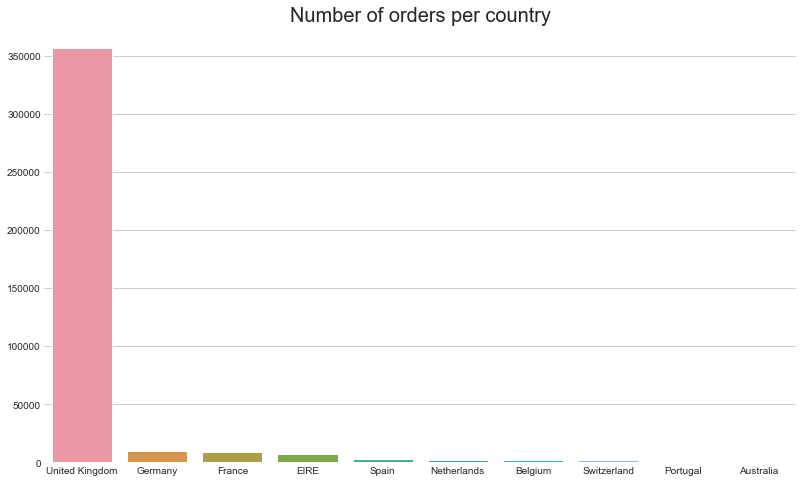

In [30]:
plt.figure(figsize = (12,8))
sns.set_style("whitegrid")

sns.barplot(data['Country'].value_counts().index[:10], data['Country'].value_counts().values[:10])
plt.title('Number of orders per country', fontsize = 20)

sns.despine(left = True, bottom = True)

We can see that most of the orders are comingfrom the UK.

___
### 2.2 Customers and products

The dataframe contains about 400K entries. What are the number of users and products in these entries ?

In [34]:
pd.DataFrame([
    {'Number_of_unique_Products' : data.StockCode.nunique(),
    'Number_of_unique_invoices' : data.InvoiceNo.nunique(),
    'Number_of_unique_customers' : data.CustomerID.nunique()}],
    index = ['Overview']
)

Number_of_unique_Products  Number_of_unique_invoices  Number_of_unique_customers
Overview                       3684                      22190                        4372

### Let's take a look at number of products purchased in every transaction:

In [35]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

CustomerID InvoiceNo  Number of products
0      12346    541431                   1
1      12346   C541433                   1
2      12347    537626                  31
3      12347    542237                  29
4      12347    549222                  24
5      12347    556201                  18
6      12347    562032                  22
7      12347    573511                  47
8      12347    581180                  11
9      12348    539318                  17

NOTE: 

- the existence of entries with the prefix C for the **InvoiceNo** variable: this indicates transactions that have been canceled
- the existence of users who only came once and only purchased one product (e.g. nº12346)
- the existence of frequent users that buy a large number of items at each order

### 2.2.1 Cancelling orders 


First of all, I count the number of transactions corresponding to canceled orders:

In [45]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
display(nb_products_per_basket.head())

n1 = nb_products_per_basket['order_canceled'].sum()
n2 = nb_products_per_basket.shape[0]
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

CustomerID InvoiceNo  Number of products  order_canceled
0      12346    541431                   1               0
1      12346   C541433                   1               1
2      12347    537626                  31               0
3      12347    542237                  29               0
4      12347    549222                  24               0

Number of orders canceled: 3654/22190 (16.47%) 


We note that the number of cancellations is quite large ($\sim$16% of the total number of transactions).
Now, let's look at the first lines of the dataframe:

In [226]:
data.sort_values('CustomerID')[:5]

InvoiceNo StockCode                         Description  Quantity  \
61619     541431     23166      MEDIUM CERAMIC TOP STORAGE JAR     74215   
61624    C541433     23166      MEDIUM CERAMIC TOP STORAGE JAR    -74215   
286623    562032     22375   AIRLINE BAG VINTAGE JET SET BROWN         4   
72260     542237     84991         60 TEATIME FAIRY CAKE CASES        24   
14943     537626     22772  PINK DRAWER KNOB ACRYLIC EDWARDIAN        12   

               InvoiceDate  UnitPrice CustomerID         Country  
61619  2011-01-18 10:01:00       1.04      12346  United Kingdom  
61624  2011-01-18 10:17:00       1.04      12346  United Kingdom  
286623 2011-08-02 08:48:00       4.25      12347         Iceland  
72260  2011-01-26 14:30:00       0.55      12347         Iceland  
14943  2010-12-07 14:57:00       1.25      12347         Iceland

On these few lines, we see that when an order is canceled, we have another transaction in the dataframe, mostly identical except for the **Quantity** and **InvoiceDate** variables. I decide to check if this is true for all the entries.
To do this, I decide to locate the entries that indicate a negative quantity and check if there is *systematically* an order indicating the same quantity (but positive), with the same description (**CustomerID**, **Description** and **UnitPrice**):

In [47]:
df_check = data[data['Quantity'] < 0][['CustomerID','Quantity',
                                                   'StockCode','Description','UnitPrice']]
for index, col in  df_check.iterrows():
    if data[(data['CustomerID'] == col[0]) & (data['Quantity'] == -col[1]) 
                & (data['Description'] == col[2])].shape[0] == 0: 
        print(df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


We see that the initial hypothesis is not fulfilled because of the existence of a  '_Discount_' entry. I check again the hypothesis but this time discarding the '_Discount_' entries:

In [48]:
df_check = data[(data['Quantity'] < 0) & (data['Description'] != 'Discount')][
                                 ['CustomerID','Quantity','StockCode',
                                  'Description','UnitPrice']]

for index, col in  df_check.iterrows():
    if data[(data['CustomerID'] == col[0]) & (data['Quantity'] == -col[1]) 
                & (data['Description'] == col[2])].shape[0] == 0: 
        print(index, df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

154 CustomerID                               15311
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


In [49]:
# try to match all cancellation orders with all previous purchase orders
cancels=data[(data['Description']!='Discount')&(data['Quantity']<0)].copy()
cancels['cancel_idx']=cancels.index
df_match=data.copy()
df_match['match_idx']=df_match.index
df_match=df_match[df_match['Quantity']>0]
mg=cancels.merge(df_match[['InvoiceDate','CustomerID','StockCode','Quantity','match_idx']],how='left',
              left_on=['CustomerID','StockCode'],right_on=['CustomerID','StockCode'])
matched=mg[mg['InvoiceDate_x']>mg['InvoiceDate_y']]
matched['match_idx']=matched['match_idx'].astype(int)
matched['Quantity_y']=matched['Quantity_y'].astype(int)
# sort data to make sure matching starts with the latest purchase order
matched=matched.sort_values(['cancel_idx','InvoiceDate_y'],ascending=[1,0])

In [50]:
# since one purchase order can be matched to multiple cancellation orders,
# it can happen that one purchase order is accounted for too many cancellation orders
# e.g. the purchase order only listed 8 units in quantity, 
# but is used to match multiple cancallation orders of which the quantities sum up to more than 8
# in other words, this purchase order is double counted
# the following codes handle this problem
count=1
while True:
    # if a customer returns items that were bought through multiple purchases
    # start accounts for the returned quantity from the latest order
    # until all returned/canceled quantity is accounted for and linked to a purchase order
    # it is possible that not all the canceled quantity can be accounted for
    matched['tot_bought']=matched.groupby('cancel_idx')['Quantity_y'].cumsum()
    matched['tot_bought_lag1']=matched.groupby('cancel_idx')['tot_bought'].shift(1).fillna(0)
    matched['QuantityCanceled']=matched[['Quantity_x','Quantity_y','tot_bought','tot_bought_lag1']].\
                                 apply(lambda x: min(-x[0],x[1]) if x[3]==0 else \
                                       (x[1] if x[2]<=-x[0] else \
                                       (0 if x[3]>=-x[0] else -x[0]-x[3])), axis=1).astype(int)
    # add a column to track the total quantity a given purchae order has been used to account for a cancellation
    # if the total quantity counted exceeds the number of units that were bought in this order
    # remove this purchase order from the candidate lists of all cancellation orders from this point on
    # iterate one more time to link cancellations to purchases
    matched['tot_QuantityCanceled']=matched.groupby('match_idx')['QuantityCanceled'].cumsum()
    double_count=len(matched[matched['tot_QuantityCanceled']>matched['Quantity_y']])
    print('Iteration {} double counted: {} times'.format(count, double_count))
    if double_count>0:
        matched=matched[matched['tot_QuantityCanceled']<=matched['Quantity_y']]
        count+=1
    else:
        print('End iteration')
        break

Iteration 1 double counted: 96 times
Iteration 2 double counted: 10 times
Iteration 3 double counted: 4 times
Iteration 4 double counted: 3 times
Iteration 5 double counted: 2 times
Iteration 6 double counted: 0 times
End iteration


In [58]:
tot_canceled=matched.groupby('cancel_idx')['Quantity_x'].mean()*(-1)
tot_bought=matched.groupby('cancel_idx')['Quantity_y'].sum()
# some but not all units of the cancellation are accounted for and linked to purchase orders
partial_doubtful_entry=tot_canceled[tot_canceled>tot_bought].index.tolist()
# all units of the cancellation are accounted for and linked to purchase orders
entry_to_remove=tot_canceled[tot_canceled<=tot_bought].index.tolist()
# no previous purchase that match the cancellation can be found
doubtful_entry=list(set(mg['cancel_idx'].unique())-set(partial_doubtful_entry)-set(entry_to_remove))

In [59]:
df_cleaned = data.copy(deep = True)
df_cleaned=df_cleaned.merge(pd.DataFrame(matched[['match_idx','tot_QuantityCanceled']].groupby('match_idx').max()),
                            how='left',left_index=True, right_index=True)
df_cleaned.rename(columns={'tot_QuantityCanceled':'QuantityCanceled'},inplace=True)
df_cleaned['QuantityCanceled']=df_cleaned['QuantityCanceled'].fillna(0).astype(int)

In [60]:
df_cleaned.head()

InvoiceNo StockCode                          Description  Quantity         InvoiceDate  UnitPrice CustomerID         Country  QuantityCanceled
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6 2010-12-01 08:26:00       2.55      17850  United Kingdom                 0
1    536365     71053                  WHITE METAL LANTERN         6 2010-12-01 08:26:00       3.39      17850  United Kingdom                 0
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8 2010-12-01 08:26:00       2.75      17850  United Kingdom                 0
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6 2010-12-01 08:26:00       3.39      17850  United Kingdom                 0
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6 2010-12-01 08:26:00       3.39      17850  United Kingdom                 0

Once more, we find that the initial hypothesis is not verified. Hence, cancellations do not necessarily correspond to orders that would have been made beforehand.

At this point, I decide to create a new field in the dataframe that indicates if part of the order has been canceled. For the cancellations without counterparts, a few of them are probably due to the fact that the buy orders were performed before December 2010 (the point of entry of the database). Below, I make a census of the canceled orders and check for the existence of counterparts:

In [62]:
print(f"Entry_to_remove: {len(entry_to_remove)} ({len(entry_to_remove)/len(data)*100:.2f}%)")
print(f"Doubtful_entry: {len(doubtful_entry)} ({len(doubtful_entry)/len(data)*100:.2f}%)")
print(f"Partial_doubtful_entry: {len(partial_doubtful_entry)} ({len(partial_doubtful_entry)/len(data)*100:.2f}%)")

Entry_to_remove: 7476 (1.86%)
Doubtful_entry: 1267 (0.32%)
Partial_doubtful_entry: 52 (0.01%)


* We will remove all of them...

In [63]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtful_entry, axis = 0, inplace = True)
df_cleaned.drop(partial_doubtful_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]

In [65]:
# Output a profile of the cleaned data
profile = pandas_profiling.ProfileReport(df_cleaned)
profile

# Let's take a look at purchases per month, day, hour

* This might lead us to conclusion about some trends regarding the email marketing campaign.

In [66]:
df_cleaned['Month'] = df_cleaned["InvoiceDate"].map(lambda x: x.month)
df_cleaned['Weekday'] = df_cleaned["InvoiceDate"].map(lambda x: x.weekday())
df_cleaned['Day'] = df_cleaned["InvoiceDate"].map(lambda x: x.day)
df_cleaned['Hour'] = df_cleaned["InvoiceDate"].map(lambda x: x.hour)

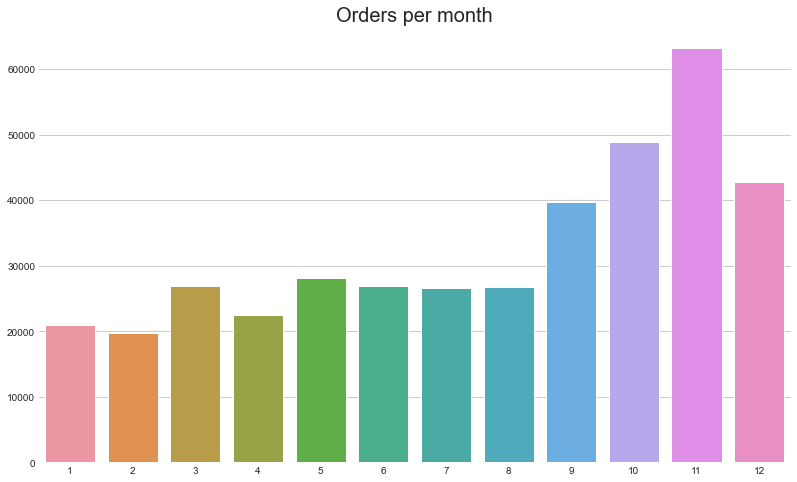

In [67]:
# orders per month

plt.figure(figsize = (12, 8))

sns.barplot(df_cleaned['Month'].value_counts().index, df_cleaned['Month'].value_counts().values)
plt.title('Orders per month', fontsize = 20)

sns.despine(left = True, bottom = True)

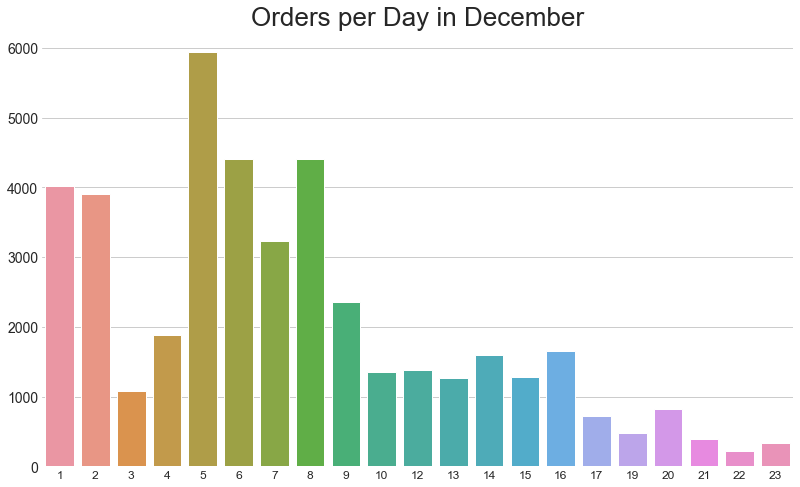

In [69]:
# orders per day in December

december = df_cleaned.loc[df_cleaned['Month'] == 12]

plt.figure(figsize = (12, 8))
sns.set_style('whitegrid')
sns.barplot(december.Day.value_counts().index, december.Day.value_counts().values)
plt.title('Orders per Day in December', fontsize = 26)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 14)



sns.despine(left = True, bottom = True)

- It's worth inspecting why there is a significant drop of after Dec 9th.

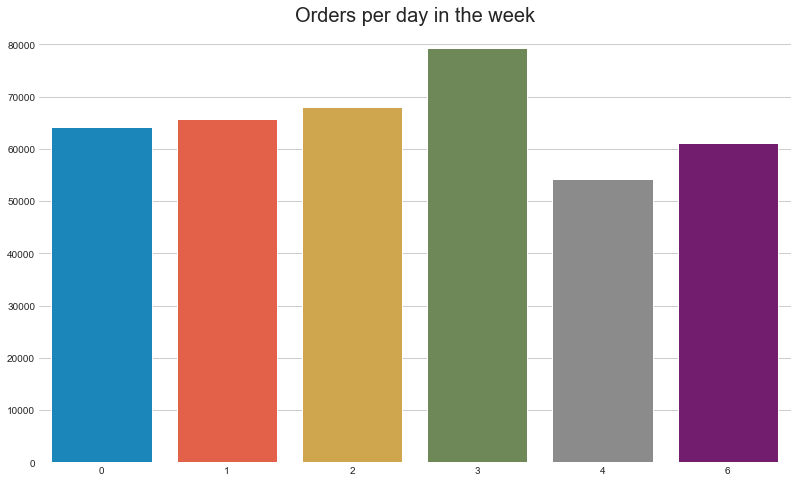

In [72]:
# orders per day in the week

plt.figure(figsize = (12, 8))

sns.barplot(df_cleaned['Weekday'].value_counts().index, df_cleaned['Weekday'].value_counts().values)
plt.title('Orders per day in the week', fontsize = 20)

sns.despine(left = True, bottom = True)

NOTE:

- Monday is represented by 0 and Sunday is represented by 6
- There's no value 5(Saturday). It's not really possible that there are no orders on Saturday. We should double check that.

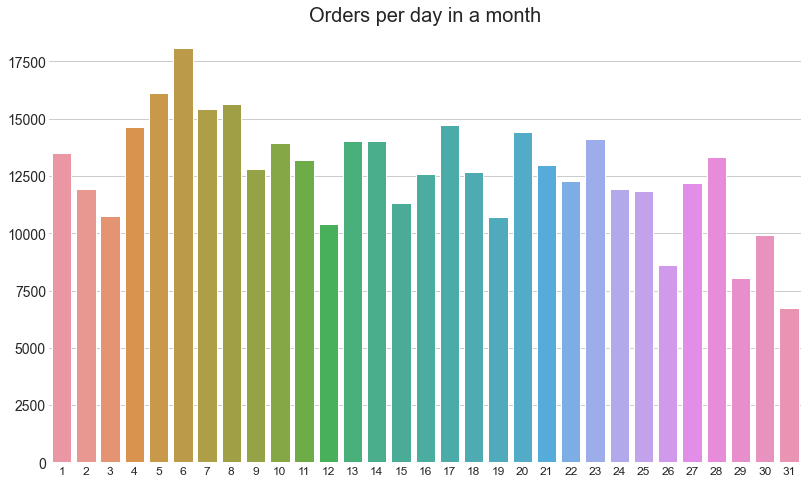

In [74]:
# orders per day in a month

plt.figure(figsize = (12, 8))

sns.barplot(df_cleaned['Day'].value_counts().index, df_cleaned['Day'].value_counts().values)
plt.title('Orders per day in a month', fontsize = 20)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 14)

sns.despine(left = True, bottom = True)

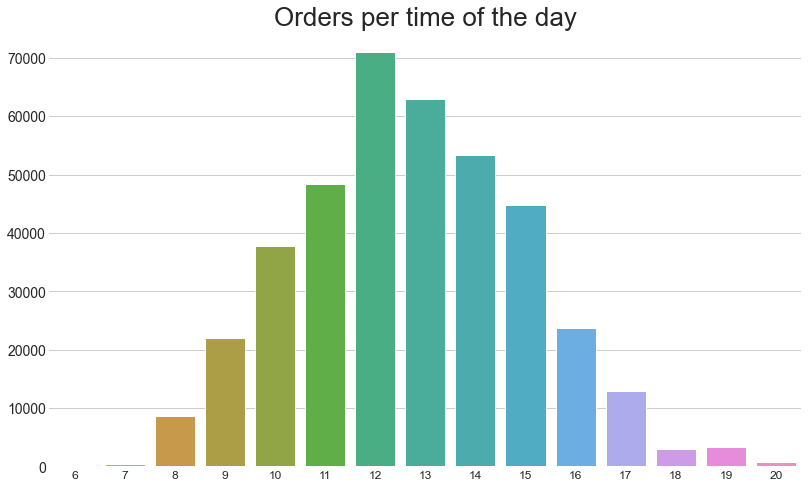

In [75]:
# orders per time of the day

plt.figure(figsize = (12, 8))

sns.barplot(df_cleaned['Hour'].value_counts().index, df_cleaned['Hour'].value_counts().values)
plt.title('Orders per time of the day', fontsize = 26)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 14)
sns.despine(left = True, bottom = True)

### 2.2.2 StockCode

- Check the contents of this field by looking for the set of codes that would contain only letters:

In [76]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

In [77]:
for code in list_special_codes:
    print("{:<15} -> {:<30}".format(code, df_cleaned[df_cleaned['StockCode'] == code]['Description'].unique()[0]))

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                


In [78]:
print("Number of entries with a peculiar stock code is {}".format(len(df_cleaned[df_cleaned['StockCode'].isin(list_special_codes)])))

Number of entries with a peculiar stock code is 1626


- For purposes of our analysis we will exclude rows with peculiar stock code

In [79]:
df_cleaned=df_cleaned[-df_cleaned['StockCode'].isin(list_special_codes)]


### 2.2.3 Basket Price

In [80]:
# Create a new col, TotalPrice, that indicates the total price of every purchase:

df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('CustomerID')[:5]

InvoiceNo StockCode                         Description  Quantity         InvoiceDate  UnitPrice CustomerID         Country  QuantityCanceled  Month  Weekday  Day  Hour  TotalPrice
61619     541431     23166      MEDIUM CERAMIC TOP STORAGE JAR     74215 2011-01-18 10:01:00       1.04      12346  United Kingdom             74215      1        1   18    10         0.0
286626    562032     22371        AIRLINE BAG VINTAGE TOKYO 78         8 2011-08-02 08:48:00       4.25      12347         Iceland                 0      8        1    2     8        34.0
428996    573511     23308  SET OF 60 VINTAGE LEAF CAKE CASES         24 2011-10-31 12:25:00       0.55      12347         Iceland                 0     10        0   31    12        13.2
428997    573511     84991         60 TEATIME FAIRY CAKE CASES        24 2011-10-31 12:25:00       0.55      12347         Iceland                 0     10        0   31    12        13.2
428998    573511     84992      72 SWEETHEART FAIRY CAKE CASES        24 2011-10-31 12:25:00       0.55      12347         Iceland                 0     10        0   31    12        13.2

### Let's group by all the purchases made during a single order(with the same invoice number) to get the total order price:

In [247]:
# # sum of purchases / user and orders
# temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
# basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})
# #_____________________
# # order date
# df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
# temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
# df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
# basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])
# #______________________________________
# # selection of significant entries:
# basket_price = basket_price[basket_price['Basket Price'] > 0]
# basket_price.sort_values('CustomerID')[:6]

CustomerID InvoiceNo  Basket Price                   InvoiceDate
1      12347    537626        711.79 2010-12-07 14:57:00.000001024
2      12347    542237        475.39 2011-01-26 14:29:59.999999744
3      12347    549222        636.25 2011-04-07 10:42:59.999999232
4      12347    556201        382.52 2011-06-09 13:01:00.000000256
5      12347    562032        584.91 2011-08-02 08:48:00.000000000
6      12347    573511       1294.32 2011-10-31 12:25:00.000001280

In [92]:
temp = pd.DataFrame(df_cleaned.groupby(['CustomerID', 'InvoiceNo', 'InvoiceDate'], 
                                        as_index = False)['TotalPrice'].sum())

# select only orders that have a TotalPrice > 0

basket_price = temp.loc[temp.TotalPrice > 0]
basket_price

CustomerID InvoiceNo         InvoiceDate  TotalPrice
1          12347    537626 2010-12-07 14:57:00      711.79
2          12347    542237 2011-01-26 14:30:00      475.39
3          12347    549222 2011-04-07 10:43:00      636.25
4          12347    556201 2011-06-09 13:01:00      382.52
5          12347    562032 2011-08-02 08:48:00      584.91
...          ...       ...                 ...         ...
18430      18283    579673 2011-11-30 12:59:00      220.31
18431      18283    580872 2011-12-06 12:02:00      208.00
18432      18287    554065 2011-05-22 10:39:00      765.28
18433      18287    570715 2011-10-12 10:23:00     1001.32
18434      18287    573167 2011-10-28 09:29:00       70.68

[18305 rows x 4 columns]

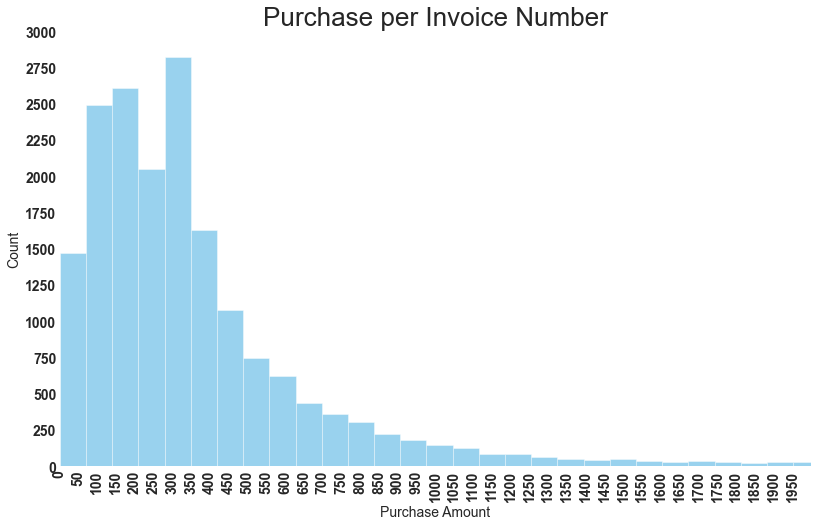

In [112]:
# Show distribution of basket prices HISTOGRAM. 
# We will show only basket price 0 - 2000 because there're not a lot basket prices > 2000

plt.figure(figsize = ( 12, 8))
sns.set_style('white')
sns.distplot(basket_price['TotalPrice'], bins=400, kde = False)
plt.xlim(0,2000)
plt.ylim(0, 3000)
plt.xticks(np.arange(0, 2000, 50), fontsize = 14, rotation = 90)
plt.title('Purchase per Invoice Number', fontsize = 26)
plt.yticks(np.arange(0, 3001, 250), fontsize = 14)
plt.xlabel('Purchase Amount', fontsize = 14)
plt.ylabel('Count', fontsize = 14)



sns.despine(left = True, bottom = True)

- Basket prices are right skewed. It's interesting to note a spike around 300-350, and around 100-200. 



____
## 3. Insight on product categories

In the dataframe, products are uniquely identified through the **StockCode** field, we cleaned this one in a previous step. A short description of the products is given in the **Description** field. In this section, I intend to use the content of this latter variable in order to group the products into different categories.

___
### 3.1 Products Description

As a first step, I extract from the **Description** field the information that will prove useful. To do this, I use the following function:

In [113]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, colonne = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("Nb of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

This function takes as input the dataframe and analyzes the content of the **Description** column by performing the following operations:

- extract the names (proper, common) appearing in the products description
- for each name, I extract the root of the word and aggregate the set of names associated with this particular root
- count the number of times each root appears in the dataframe
- when several words are listed for the same root, I consider that the keyword associated with this root is the shortest name (this systematically selects the singular when there are singular/plural variants)

The first step of the analysis is to retrieve the list of products:

In [118]:
df_produits = pd.DataFrame(df_cleaned['Description'].unique()).rename(columns = {0:'Description'})

Once this list is created, I use the function I previously defined in order to analyze the description of the various products:

In [119]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_produits)

Nb of keywords in variable 'Description': 1476


The execution of this function returns three values:
- `keywords`: the list of extracted keywords
- `keywords_roots`: a dictionary where the keys are the keywords roots and the values are the lists of words associated with those roots
- `count_keywords`: dictionary listing the number of times every word is used

At this point, I convert the `count_keywords` dictionary into a list, to sort the keywords according to their occurences:

In [120]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

Using it, I create a representation of the most common keywords:

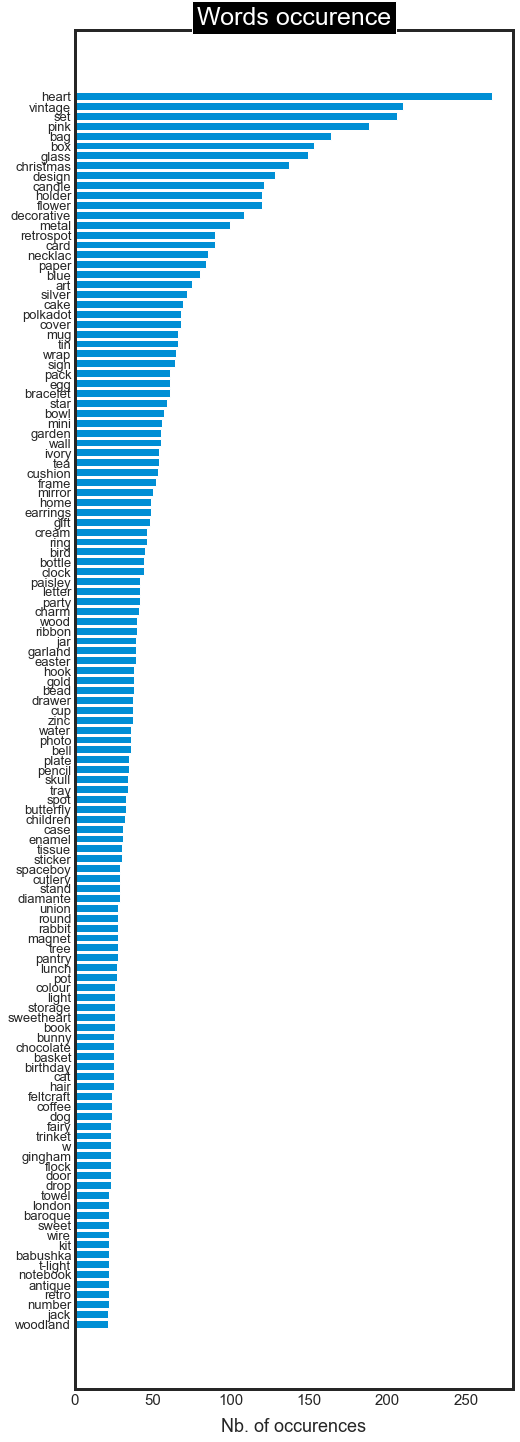

In [121]:
liste = sorted(list_products, key = lambda x:x[1], reverse = True)
#_______________________________
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()
#_______________________________________________________________________________________
plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

___
### 3.2 Defining product categories 

The list that was obtained contains more than 1400 keywords and the most frequent ones appear in more than 200 products. However, while examinating the content of the list, I note that some names are useless. Others are do not carry information, like colors. Therefore, I discard these words from the analysis that follows and also, I decide to consider only the words that appear more than 13 times.

In [ ]:
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('stopwords')
# from nltk.corpus import stopwords

In [125]:

# use predefined list of stopwords from NLTK package
nltk_stopwords = set(stopwords.words('english'))
# basic function that removes matched stopwords from a dictionary object
def remove_stopwords(corpus: dict):
    temp_dict = {} # create a temporary dictionary
    tokens = keywords_select.keys()
    filtered_tokens = list(filter(lambda token: token not in nltk_stopwords, tokens)) # filter for stopwords
    for i in filtered_tokens: # update the temporary dictionary
        temp_dict.update({i: i})
    print(f'{len(keywords_select.keys())-len(temp_dict.keys())} stopwords removed')
    return temp_dict

In [126]:
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange',
               'box', 'sign', 'vintage', 'glass', 'light', 'candle', 'flower']: continue
    if len(word) < 5 or v < 13: continue # ovde sam promenio 3 u 5
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
#______________________________________________________    
list_products.sort(key = lambda x:x[1], reverse = True)
print('preserved words:', len(list_products))

preserved words: 124


In [127]:
# use predefined list of stopwords from NLTK package
nltk_stopwords = set(stopwords.words('english'))
# basic function that removes matched stopwords from a dictionary object
def remove_stopwords(corpus: dict):
    temp_dict = {} # create a temporary dictionary
    tokens = keywords_select.keys()
    filtered_tokens = list(filter(lambda token: token not in nltk_stopwords, tokens)) # filter for stopwords
    for i in filtered_tokens: # update the temporary dictionary
        temp_dict.update({i: i})
    print(f'{len(keywords_select.keys())-len(temp_dict.keys())} stopwords removed')
    return temp_dict

In [128]:
keywords_select = remove_stopwords(keywords_select) # also prints how many stopwords were removed

9 stopwords removed


In [129]:
# reflect the change on 'count_keywords' dict, too
count_keywords = {k: v for k, v in count_keywords.items() if k in keywords_select.keys()}

In [130]:
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange'\
                'box', 'sign', 'vintage', 'glass', 'light', 'candle', 'flower']: continue
    if len(word) < 5 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
#______________________________________________________    
list_products.sort(key = lambda x:x[1], reverse = True)
print('preserved words:', len(list_products))

preserved words: 120


____
#### 3.2.1 Data encoding

Now I will use these keywords to create groups of product. Firstly, I define the $X$ matrix as:

   
|   | mot 1  |  ...  | mot j  | ...  | mot N  |
|:-:|---|---|---|---|---|
| product 1  | $a_{1,1}$  |     |   |   | $a_{1,N}$  |
| ...        |            |     | ...  |   |   |
|product i   |    ...     |     | $a_{i,j}$    |   | ...  |
|...         |            |     |  ... |   |   |
| product M  | $a_{M,1}$  |     |   |   | $a_{M,N}$   |

where the $a_ {i, j}$ coefficient  is 1 if the description of the product $i$ contains the word $j$, and 0 otherwise. Here I have a row for each product and a column for each keyword. I fill in the entries with zero or 1, depending on whether that product has that keyword in its description.

In [132]:
liste_produits = df_cleaned['Description'].unique()
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), liste_produits))
X

heart  vintag  christma  design  candl  holder  decor  metal  retrospot  necklac  paper  silver  polkadot  cover  bracelet  garden  ivori  cushion  frame  mirror  earring  cream  bottl  clock  paisley  letter  parti  charm  ribbon  garland  easter  drawer  water  photo  plate  pencil  skull  butterfli  children  enamel  tissu  sticker  spaceboy  cutleri  stand  diamant  union  round  rabbit  magnet  ...  t-light  notebook  antiqu  retro  number  woodland  cabinet  strawberri  wicker  daisi  shell  kitchen  dinner  style  hanger  chick  doormat  doiley  warmer  wreath  stripe  shape  parasol  travel  doili  biscuit  regenc  jigsaw  coaster  cherri  money  cottag  incens  crystal  medium  pictur  wooden  bathroom  fruit  child  orbit  alphabet  toadstool  funki  plant  diner  squar  craft  wallet  point
0         1       0         0       0      0       1      0      0          0        0      0       0         0      0         0       0      0        0      0       0        0      0      0      0        0       0      0      0       0        0       0       0      0      0      0       0      0          0         0       0      0        0         0        0      0        0      0      0       0       0  ...        1         0       0      0       0         0        0           0       0      0      0        0       0      0       0      0        0       0       0       0       0      0        0       0      0        0       0       0        0       0      0       0       0        0       0       0       0         0      0      0      0         0          0      0      0      0      0      0       0      0
1         0       0         0       0      0       0      0      1          0        0      0       0         0      0         0       0      0        0      0       0        0      0      0      0        0       0      0      0       0        0       0       0      0      0      0       0      0          0         0       0      0        0         0        0      0        0      0      0       0       0  ...        0         0       0      0       0         0        0           0       0      0      0        0       0      0       0      0        0       0       0       0       0      0        0       0      0        0       0       0        0       0      0       0       0        0       0       0       0         0      0      0      0         0          0      0      0      0      0      0       0      0
2         1       0         0       0      0       0      0      0          0        0      0       0         0      0         0       0      0        0      0       0        0      1      0      0        0       0      0      0       0        0       0       0      0      0      0       0      0          0         0       0      0        0         0        0      0        0      0      0       0       0  ...        0         0       0      0       0         0        0           0       0      0      0        0       0      0       1      0        0       0       0       0       0      0        0       0      0        0       0       0        0       0      0       0       0        0       0       0       0         0      0      0      0         0          0      0      0      0      0      0       0      0
3         0       0         0       0      0       0      0      0          0        0      0       0         0      0         0       0      0        0      0       0        0      0      1      0        0       0      0      0       0        0       0       0      1      0      0       0      0          0         0       0      0        0         0        0      0        0      1      0       0       0  ...        0         0       0      0       0         0        0           0       0      0      0        0       0      0       0      0        0       0       0       0       0      0        0       0      0        0       0       0        0       0      0       0       0        0       0       0       0         0    

The $X$ matrix indicates the words contained in the description of the products using the *one-hot-encoding* principle. In practice, I have found that introducing the price range results in more balanced groups in terms of element numbers.
Hence, I add 6 extra columns to this matrix, where I indicate the price range of the products:

In [133]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(liste_produits):
    prix = df_cleaned[ df_cleaned['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

and to choose the appropriate ranges, I check the number of products in the different groups:

In [134]:
print("{:<8} {:<20} \n".format('gamme', 'nb. produits') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

gamme    nb. produits         
--------------------
0<.<1       963                 
1<.<2       1009                
2<.<3       673                 
3<.<5       606                 
5<.<10      470                 
.>10        150                 


____
#### 3.2.2 Creating clusters of products

In this section, I will group the products into different classes. In the case of matrices with binary encoding, a better metric for the calculation of distances is a dot product or [Hamming's metric](https://en.wikipedia.org/wiki/Distance_de_Hamming). Note that the **kmeans** method of sklearn uses a Euclidean distance that can be used, but it is not to the best choice in the case of categorical variables. However, in order to use the Hamming's metric, we need to use the [kmodes](https://pypi.python.org/pypi/kmodes/) package which is not available on the current plateform. Hence, I use the **kmeans** method even if this is not the best choice.

In order to define (approximately) the number of clusters that best represents the data, I use the silhouette score:

In [135]:
# matrix = X.as_matrix()
matrix = X.to_numpy()
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.19155000644827183
For n_clusters = 4 The average silhouette_score is : 0.23886849296445864
For n_clusters = 5 The average silhouette_score is : 0.27658899110684326
For n_clusters = 6 The average silhouette_score is : 0.2939998949009723
For n_clusters = 7 The average silhouette_score is : 0.27064460699803083
For n_clusters = 8 The average silhouette_score is : 0.2642310909914977
For n_clusters = 9 The average silhouette_score is : 0.2592027440198397


- Usually we are looking for the highest silhouette score while assessing how many clusters of products we want. For our project we will move forward with 5 clusters.

In [136]:
# k means clustering gets different results each time you run it because of the random initialization, 
# so run it a few times and look for a particular run that has a silhouette score that's pretty good.

n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 5 The average silhouette_score is : 0.2737668358797812


___
#### 3.2.3  Characterizing the content of clusters

I check the number of elements in every class:

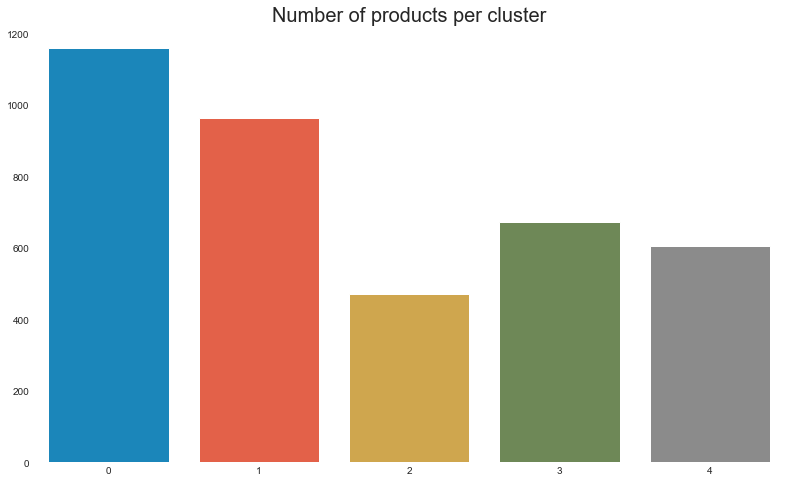

In [138]:
plt.figure(figsize = (12,8))

sns.barplot(pd.Series(clusters).value_counts().index, pd.Series(clusters).value_counts().values)

plt.title('Number of products per cluster', fontsize = 20)

sns.despine(left = True, bottom = True)


** a / _Silhouette intra-cluster score_ **

In order to have an insight on the quality of the classification, we can represent the silhouette scores of each element of the different clusters. This is the purpose of the next figure which is taken from the [sklearn documentation](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html):

In [139]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
#     plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    #____________________________
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        #___________________________________________________________________________________
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)
        #____________________________________________________________________
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
        #______________________________________
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  

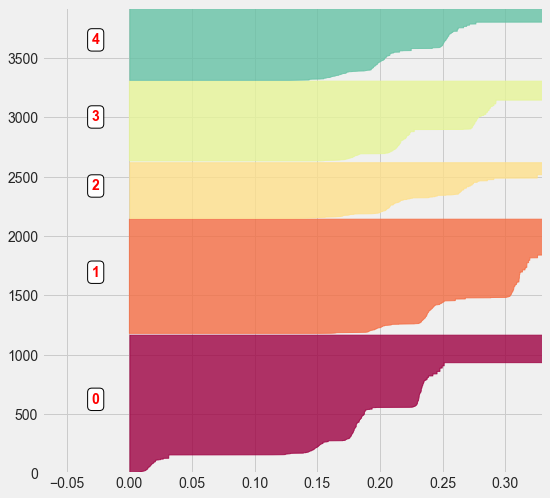

In [140]:
#____________________________________
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(matrix, clusters)
#__________________
# and do the graph
graph_component_silhouette(n_clusters, [-0.07, 0.33], len(X), sample_silhouette_values, clusters)

** b/ _Word Cloud_**

Now we can have a look at the type of objects that each cluster represents. In order to obtain a global view of their contents, I determine which keywords are the most frequent in each of them

In [141]:
liste = pd.DataFrame(liste_produits)
liste_words = [word for (word, occurence) in list_products]

occurence = [dict() for _ in range(n_clusters)]

for i in range(n_clusters):
    liste_cluster = liste.loc[clusters == i]
    for word in liste_words:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag',
                   'metal', 'holder', 'design', 'retro']: continue # made changes here
        occurence[i][word] = sum(liste_cluster.loc[:, 0].str.contains(word.upper()))

and I output the result as wordclouds:

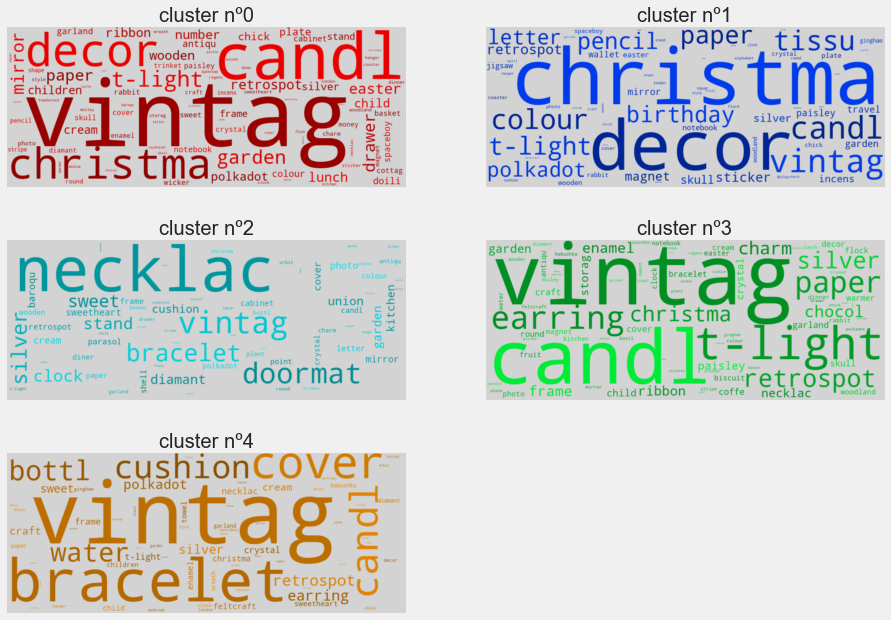

In [142]:
#________________________________________________________________________
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)
#________________________________________________________________________
def make_wordcloud(liste, increment):
    ax1 = fig.add_subplot(4,2,increment)
    words = dict()
    trunc_occurences = liste[0:150]
    for s in trunc_occurences:
        words[s[0]] = s[1]
    #________________________________________________________
    wordcloud = WordCloud(width=1000,height=400, background_color='lightgrey', 
                          max_words=1628,relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster nº{}'.format(increment-1))
#________________________________________________________________________
fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(n_clusters):
    list_cluster_occurences = occurence[i]

    tone = color[i] # define the color of the words
    liste = []
    for key, value in list_cluster_occurences.items():
        liste.append([key, value])
    liste.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(liste, i+1)            

In [143]:
prods=pd.DataFrame([liste_produits,clusters]).T
prods.columns=['prod','cluster']
prods['cluster'].value_counts()

0    1159
1     963
3     673
4     606
2     470
Name: cluster, dtype: int64

###  We grouped products in 5 clusters. In order to prepare the rest of the analysis, a first step consists in introducing this information into the dataframe. To do this, I create the categorical variable categ_product where I indicate the cluster of each product 

In [175]:
corresp = dict()
for key, val in zip (liste_produits, clusters):
    corresp[key] = val 
#__________________________________________________________________________
df_cleaned['categ_product'] = df_cleaned.loc[:, 'Description'].map(corresp)

In [177]:
df_cleaned.head()

InvoiceNo StockCode                          Description  Quantity         InvoiceDate  UnitPrice CustomerID         Country  QuantityCanceled  Month  Weekday  Day  Hour  TotalPrice  categ_product
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6 2010-12-01 08:26:00       2.55      17850  United Kingdom                 0     12        2    1     8       15.30              3
1    536365     71053                  WHITE METAL LANTERN         6 2010-12-01 08:26:00       3.39      17850  United Kingdom                 0     12        2    1     8       20.34              4
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8 2010-12-01 08:26:00       2.75      17850  United Kingdom                 0     12        2    1     8       22.00              4
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6 2010-12-01 08:26:00       3.39      17850  United Kingdom                 0     12        2    1     8       20.34              4
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6 2010-12-01 08:26:00       3.39      17850  United Kingdom                 0     12        2    1     8       20.34              4

___
#### 3.3.  Top 20 products for product clusters

- We will need to analyse these results and come up with a name for each product cluster. You can find more info about analysis and the name of each cluster in .PPTX presentation that will be provided.

- Product Cluster 0

In [180]:
(df_cleaned[df_cleaned['categ_product'] == 0]['Description'].value_counts().sort_values(ascending = False)[:20])

REGENCY CAKESTAND 3 TIER              1714
ASSORTED COLOUR BIRD ORNAMENT         1395
LUNCH BAG RED RETROSPOT               1303
LUNCH BAG  BLACK SKULL.               1078
LUNCH BAG SPACEBOY DESIGN              993
HEART OF WICKER SMALL                  979
LUNCH BAG CARS BLUE                    977
LUNCH BAG PINK POLKADOT                941
LUNCH BAG SUKI DESIGN                  915
SET OF 4 PANTRY JELLY MOULDS           881
LUNCH BAG APPLE DESIGN                 878
JAM MAKING SET PRINTED                 870
LUNCH BAG WOODLAND                     831
VICTORIAN GLASS HANGING T-LIGHT        819
GARDENERS KNEELING PAD KEEP CALM       762
6 RIBBONS RUSTIC CHARM                 741
SPACEBOY LUNCH BOX                     709
LUNCH BAG ALPHABET DESIGN              660
GARDENERS KNEELING PAD CUP OF TEA      642
CLOTHES PEGS RETROSPOT PACK 24         642
Name: Description, dtype: int64

- Product Cluster 1

In [181]:
df_cleaned[df_cleaned['categ_product'] == 1]['Description'].value_counts().sort_values(ascending = False)[:20]

PACK OF 72 RETROSPOT CAKE CASES        1050
REX CASH+CARRY JUMBO SHOPPER            897
RED RETROSPOT CHARLOTTE BAG             748
SET/20 RED RETROSPOT PAPER NAPKINS      746
VINTAGE SNAP CARDS                      731
PACK OF 60 PINK PAISLEY CAKE CASES      676
60 TEATIME FAIRY CAKE CASES             672
POPCORN HOLDER                          653
CHARLOTTE BAG SUKI DESIGN               590
PACK OF 20 NAPKINS PANTRY DESIGN        554
PACK OF 60 DINOSAUR CAKE CASES          543
WOODLAND CHARLOTTE BAG                  538
COLOUR GLASS T-LIGHT HOLDER HANGING     530
SET OF 60 PANTRY DESIGN CAKE CASES      516
72 SWEETHEART FAIRY CAKE CASES          515
PACK OF 72 SKULL CAKE CASES             505
SET OF 20 VINTAGE CHRISTMAS NAPKINS     502
STRAWBERRY CHARLOTTE BAG                496
CHARLOTTE BAG PINK POLKADOT             494
60 CAKE CASES VINTAGE CHRISTMAS         479
Name: Description, dtype: int64

- Product Cluster 2

In [182]:
df_cleaned[df_cleaned['categ_product'] == 2]['Description'].value_counts().sort_values(ascending = False)[:20]

HOME BUILDING BLOCK WORD              695
DOORMAT KEEP CALM AND COME IN         652
IVORY KITCHEN SCALES                  620
WOOD BLACK BOARD ANT WHITE FINISH     604
DOORMAT RED RETROSPOT                 577
LOVE BUILDING BLOCK WORD              560
DOORMAT NEW ENGLAND                   533
CHILLI LIGHTS                         521
DOORMAT UNION FLAG                    518
WOOD 2 DRAWER CABINET WHITE FINISH    512
DOORMAT HEARTS                        481
LOVE HOT WATER BOTTLE                 459
RED KITCHEN SCALES                    449
ENAMEL FLOWER JUG CREAM               444
BAKING SET SPACEBOY DESIGN            427
RED DINER WALL CLOCK                  416
DOORMAT SPOTTY HOME SWEET HOME        405
VINTAGE UNION JACK BUNTING            400
DOORMAT FANCY FONT HOME SWEET HOME    397
IVORY DINER WALL CLOCK                394
Name: Description, dtype: int64

- Product Cluster 3

In [183]:
df_cleaned[df_cleaned['categ_product'] == 3]['Description'].value_counts().sort_values(ascending = False)[:20]

WHITE HANGING HEART T-LIGHT HOLDER     2016
JUMBO BAG RED RETROSPOT                1615
PAPER CHAIN KIT 50'S CHRISTMAS         1003
NATURAL SLATE HEART CHALKBOARD          972
JUMBO BAG PINK POLKADOT                 884
WOODEN PICTURE FRAME WHITE FINISH       882
RECIPE BOX PANTRY YELLOW DESIGN         836
RABBIT NIGHT LIGHT                      823
WOODEN FRAME ANTIQUE WHITE              816
HEART OF WICKER LARGE                   811
JUMBO SHOPPER VINTAGE RED PAISLEY       793
ROSES REGENCY TEACUP AND SAUCER         791
JUMBO STORAGE BAG SUKI                  780
JUMBO BAG VINTAGE LEAF                  779
SET/5 RED RETROSPOT LID GLASS BOWLS     773
JUMBO BAG ALPHABET                      757
JUMBO BAG APPLES                        724
PAPER CHAIN KIT VINTAGE CHRISTMAS       706
PLEASE ONE PERSON METAL SIGN            705
GREEN REGENCY TEACUP AND SAUCER         700
Name: Description, dtype: int64

- Product Cluster 4

In [184]:
df_cleaned[df_cleaned['categ_product'] == 4]['Description'].value_counts().sort_values(ascending = False)[:20]

PARTY BUNTING                        1390
SET OF 3 CAKE TINS PANTRY DESIGN     1152
SPOTTY BUNTING                       1014
ALARM CLOCK BAKELIKE RED              886
JAM MAKING SET WITH JARS              880
BAKING SET 9 PIECE RETROSPOT          858
RETROSPOT TEA SET CERAMIC 11 PC       825
ALARM CLOCK BAKELIKE GREEN            797
HOT WATER BOTTLE KEEP CALM            731
SET OF 3 REGENCY CAKE TINS            721
CHOCOLATE HOT WATER BOTTLE            706
SET OF 6 SPICE TINS PANTRY DESIGN     663
SCOTTIE DOG HOT WATER BOTTLE          661
ALARM CLOCK BAKELIKE PINK             619
RETROSPOT HEART HOT WATER BOTTLE      541
GREY HEART HOT WATER BOTTLE           531
HOT WATER BOTTLE TEA AND SYMPATHY     516
HOT WATER BOTTLE I AM SO POORLY       507
ALARM CLOCK BAKELIKE IVORY            470
CREAM HEART CARD HOLDER               454
Name: Description, dtype: int64

___
## 4. Customer categories

### 4.1 Grouping products

## Key idea is to have a table where for each invoiceNO we will have a breakdown of how much money is allocated for different clusters of products.. as a reminder, in the last step we created 5 clusters based on products, now it's time to match them with purchases

In a second step, I decide to create the **categ_N** variables (with $ N \in [0: 4]$) that contains the amount spent in each product category:

- here categ_# represents clusters so we will have categ_0...categ_4

In [185]:
for i in range(5):
    col = 'categ_{}'.format(i)        
    df_temp = df_cleaned[df_cleaned['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCanceled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)
#__________________________________________________________________________________________________
df_cleaned[['InvoiceNo', 'Description', 'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4']][:5]

InvoiceNo                          Description  categ_product  categ_0  categ_1  categ_2  categ_3  categ_4
0    536365   WHITE HANGING HEART T-LIGHT HOLDER              3      0.0      0.0      0.0     15.3     0.00
1    536365                  WHITE METAL LANTERN              4      0.0      0.0      0.0      0.0    20.34
2    536365       CREAM CUPID HEARTS COAT HANGER              4      0.0      0.0      0.0      0.0    22.00
3    536365  KNITTED UNION FLAG HOT WATER BOTTLE              4      0.0      0.0      0.0      0.0    20.34
4    536365       RED WOOLLY HOTTIE WHITE HEART.              4      0.0      0.0      0.0      0.0    20.34

### Create a table with breakdown of money spent for each invoice per product segment

In [186]:
#___________________________________________
# sum of purchases / user & order
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})
#____________________________________________________________
# percentage of the price of the order / product category
for i in range(5):
    col = 'categ_{}'.format(i) 
    temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    basket_price.loc[:, col] = temp 
#_____________________
# order date
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])
#______________________________________
# selection of significant entries:
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID', ascending = True)[:5]

CustomerID InvoiceNo  Basket Price  categ_0  categ_1  categ_2  categ_3  categ_4                   InvoiceDate
1      12347    537626        711.79   187.20    23.40   124.44    83.40   293.35 2010-12-07 14:57:00.000001024
2      12347    542237        475.39   168.75    84.34     0.00    53.10   169.20 2011-01-26 14:29:59.999999744
3      12347    549222        636.25   369.15    81.00     0.00    71.10   115.00 2011-04-07 10:42:59.999999232
4      12347    556201        382.52    74.40    41.40    19.90    78.06   168.76 2011-06-09 13:01:00.000000256
5      12347    562032        584.91   147.95    61.30    97.80   119.70   158.16 2011-08-02 08:48:00.000000000


## 4.1.2. Consumer Order Combinations

#### group together the different entries that correspond to the same user. 

- number of purchases made by the user
- minimum 
- maximum
- average amount spent
- total amount spent during all the visits
- Spending per product category as a % of total amount spent
- first purchase
- last purchase
- canceled %
- Number of unique products purchased

In [198]:

# Group all relevent information together for each customer.
#________________________________________________________________
# number of visits and stats on the cart amount / users
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() / \
                                            transactions_per_user['sum']*100

df_cleaned['CanceledValue']=df_cleaned['QuantityCanceled']*df_cleaned['UnitPrice']
transactions_per_user=transactions_per_user.merge(
    df_cleaned[['CustomerID','CanceledValue']].groupby('CustomerID').sum(),
    left_index=True,right_index=True)
transactions_per_user['canceled%']=transactions_per_user['CanceledValue']/transactions_per_user['sum']*100
transactions_per_user['canceled%']=transactions_per_user['canceled%'].apply(lambda x: 100 if x>100 else x)

transactions_per_user=transactions_per_user.merge(
    df_cleaned[['Description','CustomerID']].groupby('CustomerID').nunique().\
    rename(columns={'Description':'unique_prod'}),
    left_index=True,right_index=True)

transactions_per_user.drop(columns='CanceledValue',inplace=True)
transactions_per_user.index.name = None
transactions_per_user.reset_index(drop = False, inplace = True)

transactions_per_user.drop(columns='CustomerID', inplace=True)
transactions_per_user.rename(columns={'index':'CustomerID'}, inplace=True)
transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

CustomerID  count      min      max         mean      sum    categ_0    categ_1    categ_2    categ_3    categ_4  canceled%  unique_prod
0      12347      7   224.82  1294.32   615.714286  4310.00  30.813225  11.237123   7.604176  20.805104  29.540371   0.000000          103
1      12348      4   187.44   652.80   359.310000  1437.24  52.461663  47.538337   0.000000   0.000000   0.000000   0.000000           21
2      12349      1  1457.55  1457.55  1457.550000  1457.55  42.287400   5.442009  24.585778  14.765874  12.918939   0.000000           72
3      12350      1   294.40   294.40   294.400000   294.40  55.027174  13.281250   0.000000  31.691576   0.000000   0.000000           16
4      12352      6   104.35   296.50   210.901667  1265.41  34.647268   2.449799  27.698532   7.675773  27.528627   9.509171           57

### First purchase & Last purchase

##### We will use this later again for RFM analysis

I define two additional variables that give the number of days elapsed since the first purchase (** FirstPurchase **) and the number of days since the last purchase (** LastPurchase **):

In [199]:
last_date = basket_price['InvoiceDate'].max().date()

first_registration = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase      = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

test  = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transactions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transactions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']

transactions_per_user[:5]

CustomerID  count      min      max         mean      sum    categ_0    categ_1    categ_2    categ_3    categ_4  canceled%  unique_prod  LastPurchase  FirstPurchase
0      12347      7   224.82  1294.32   615.714286  4310.00  30.813225  11.237123   7.604176  20.805104  29.540371   0.000000          103             2            367
1      12348      4   187.44   652.80   359.310000  1437.24  52.461663  47.538337   0.000000   0.000000   0.000000   0.000000           21            75            358
2      12349      1  1457.55  1457.55  1457.550000  1457.55  42.287400   5.442009  24.585778  14.765874  12.918939   0.000000           72            18             18
3      12350      1   294.40   294.40   294.400000   294.40  55.027174  13.281250   0.000000  31.691576   0.000000   0.000000           16           310            310
4      12352      6   104.35   296.50   210.901667  1265.41  34.647268   2.449799  27.698532   7.675773  27.528627   9.509171           57            36            296

A customer category of particular interest is that of customers who make only one purchase. One of the objectives may be, for example, to target these customers in order to retain them. In part, I find that this type of customer represents 1/3 of the customers listed:

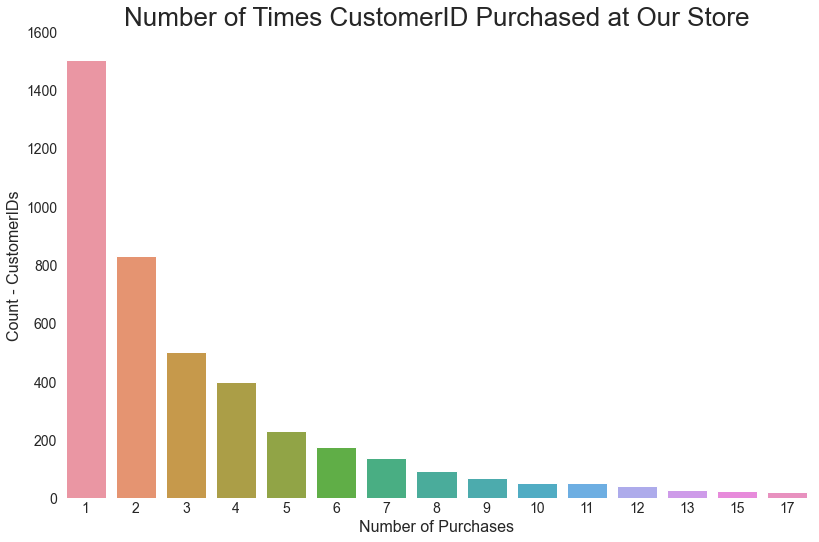

In [201]:


plt.figure(figsize = (12,8))
sns.set_style('white')
sns.barplot(transactions_per_user['count'].value_counts().index[:15], transactions_per_user['count'].value_counts().values[:15])
plt.ylim(0,1600)

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Number of Purchases', fontsize = 16)
plt.ylabel('Count - CustomerIDs', fontsize = 16)

#plt.text(3, 1200, s = '1502/4324 (about 35%) CustomerIDs\nPurchased Just Once\n\n28', fontsize = 20)



plt.title('Number of Times CustomerID Purchased at Our Store', fontsize = 26)
sns.despine(left = True, bottom = True)


In [207]:
transactions_per_user[(transactions_per_user['count'] == 1)].shape[0] / transactions_per_user.shape[0]

0.34736355226641996

- Almost 35% of customers made a purchase only once. There's a huge opportunity to engage them again and boost revenue & profits.
- Customers who made just one purchase can be there own segment. We will perform customer segmentation and later RFM analysis to enhance business understanding of all unique segments.

In [208]:
transactions_per_user[(transactions_per_user['count'] <= 3)].shape[0] / transactions_per_user.shape[0]

0.6558741905642923

- ~65% of customers made a purchase less than 4 times.

___
### 4.2 # Customer Clustering

#### 4.2.1 Data encoding

The dataframe `transactions_per_user` contains a summary of all the commands that were made. Each entry in this dataframe corresponds to a particular client. I use this information to characterize the different types of customers and only keep a subset of variables:

In [209]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4',
            'unique_prod', 'canceled%', 'LastPurchase', 'FirstPurchase']
#_____________________________________________________________
selected_customers = transactions_per_user.copy(deep = True)
matrix = selected_customers[list_cols].to_numpy()

In practice, the different variables I selected have quite different ranges of variation and before continuing the analysis, I  create a matrix where these data are standardized:

In [210]:
scaler = StandardScaler()
scaler.fit(matrix)
print('variables mean values: \n' + 90*'-' + '\n' , scaler.mean_)
scaled_matrix = scaler.transform(matrix)

variables mean values: 
------------------------------------------------------------------------------------------
 [  4.22641073 243.20878816 571.08224792 370.04821957  31.71638265
  14.26152072  14.96619883  21.89283534  17.16306247  61.87280296
   1.94377986  92.34759482 222.92599445]


In the following, I will create clusters of customers. In practice, before creating these clusters, it is interesting to define a base of smaller dimension allowing to describe the `scaled_matrix` matrix. In this case, I will use this base in order to create a representation of the different clusters and thus verify the quality of the separation of the different groups. I therefore perform a PCA beforehand:

In [211]:
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

and I represent the amount of variance explained by each of the components:

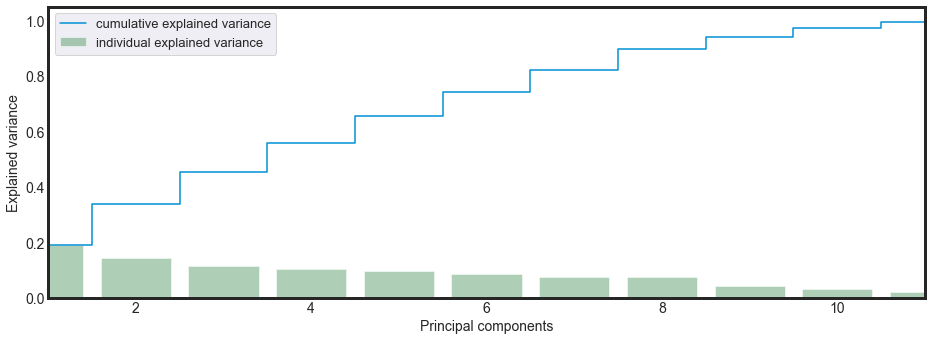

In [212]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 10)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13);

___
#### 4.2.2 Creation of customer categories

In [213]:
for n in range(6,12):
    kmeans = KMeans(init='k-means++', n_clusters = n, n_init=100)
    kmeans.fit(scaled_matrix)
    clusters_clients = kmeans.predict(scaled_matrix)
    silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
    print('number of clusters is ',n, '  silhouette score: {:<.3f}'.format(silhouette_avg))
    print(pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['nb. de clients']).T,'\n')

number of clusters is  6   silhouette score: 0.151
                   0     2     3   5   4   1
nb. de clients  1651  1531  1052  52  22  16 

number of clusters is  7   silhouette score: 0.156
                   1     2    3    6   4   0   5
nb. de clients  1538  1376  958  361  52  23  16 

number of clusters is  8   silhouette score: 0.160
                   0     1    2    7    3   5   4   6
nb. de clients  1302  1249  772  582  333  48  22  16 

number of clusters is  9   silhouette score: 0.172
                   1     3    0    2    4    8   7   5   6
nb. de clients  1181  1142  650  584  341  340  48  22  16 

number of clusters is  10   silhouette score: 0.180
                   7     0    1    5    2    6    9   8   4   3
nb. de clients  1214  1085  735  314  313  293  283  49  22  16 

number of clusters is  11   silhouette score: 0.182
                  9     4    5    1    2    0    3   10  6   8   7 
nb. de clients  1227  1091  731  316  294  292  283  50  18  16   6 



### Temporarily, based on silhouette score and trying to keep a reasonable # of customer clusters, I recommend to move forward with 9 customer clusters. Later, we might identify very similar clusters or clusters that have less than 50 or 100 customers. We will analyze those and probably join them to the bigger, most similar cluster.

In [214]:
n_clusters = 9
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('silhouette score: {:<.3f}'.format(silhouette_avg))

silhouette score: 0.172


At first, I look at the number of customers in each cluster:

In [215]:
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['nb. de clients']).T

4     3    7    0    2    1   5   6   8
nb. de clients  1182  1141  650  584  340  340  49  22  16

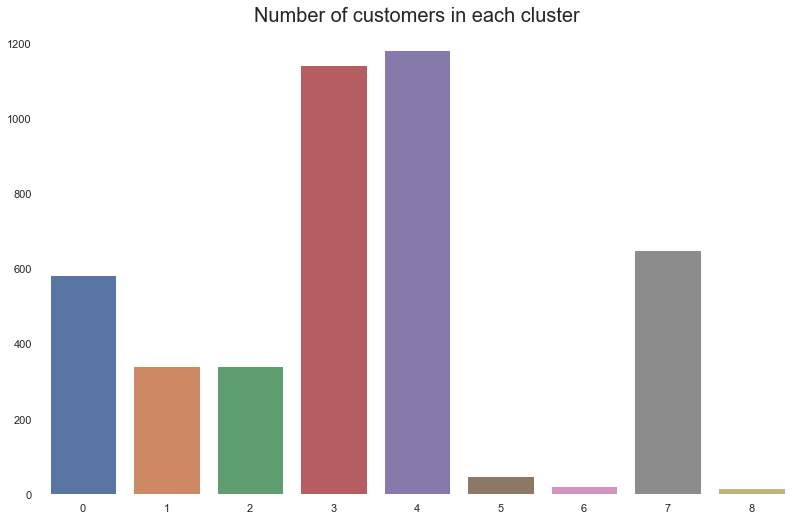

In [216]:
plt.figure(figsize = ( 12,8))
sns.set_style('white')
sns.barplot(pd.Series(clusters_clients).value_counts().index, pd.Series(clusters_clients).value_counts().values)

plt.title('Number of customers in each cluster', fontsize = 20)
sns.despine(left = True, bottom = True)

plt.show()

### We have a couple of options for clusters 5, 6, and 8. 

- Find the most similar cluster that have over 100 customers
- Keep these clusters even though they have less than 50 customers.

This is something we will need to discuss with stakeholders what makes the most sense.




** a / _Report via the PCA_ **

There is a certain disparity in the sizes of different groups that have been created. Hence I will now try to understand the content of these clusters in order to validate (or not) this particular separation. At first, I use the result of the PCA:

In [217]:
pca = PCA(n_components=6)
matrix_3D = pca.fit_transform(scaled_matrix)
mat = pd.DataFrame(matrix_3D)
mat['cluster'] = pd.Series(clusters_clients)

in order to create a representation of the various clusters:

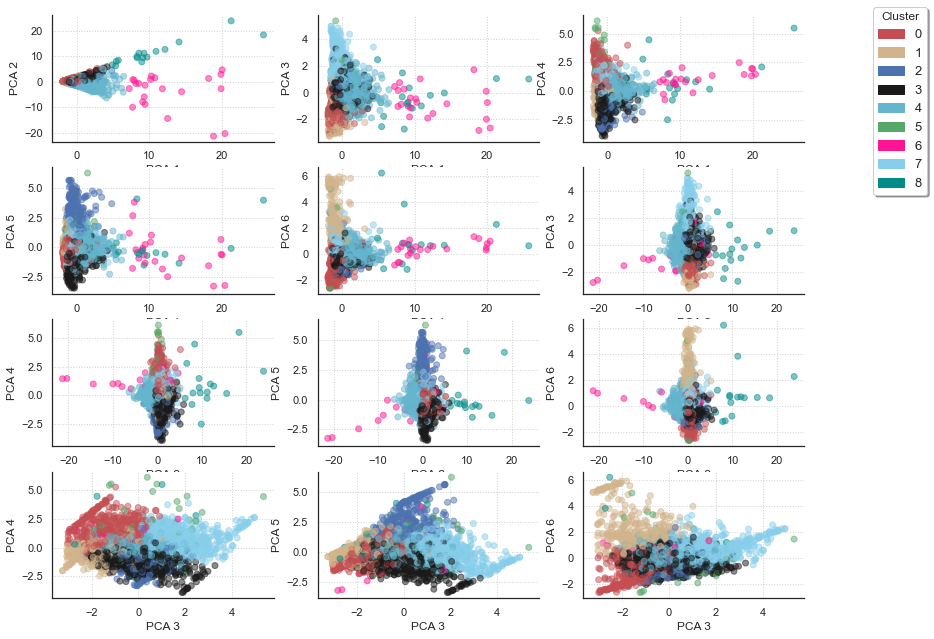

In [218]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'deeppink', 7:'skyblue', 8:'darkcyan', 9:'orange',
                   10:'yellow', 11:'tomato', 12:'seagreen'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,10))
increment = 0
for ix in range(6):
    for iy in range(ix+1, 6):   
        increment += 1
        ax = fig.add_subplot(4,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.5) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 12: break
    if increment == 12: break
        
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9), 
           title='Cluster', 
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.tight_layout()



From this representation, it can be seen, for example, that the first principal component allow to separate the tiniest clusters from the rest. More generally, we see that there is always a representation in which two clusters will appear to be distinct.

** b/ _Score de silhouette intra-cluster_ **

As with product categories, another way to look at the quality of the separation is to look at silouhette scores within different clusters:

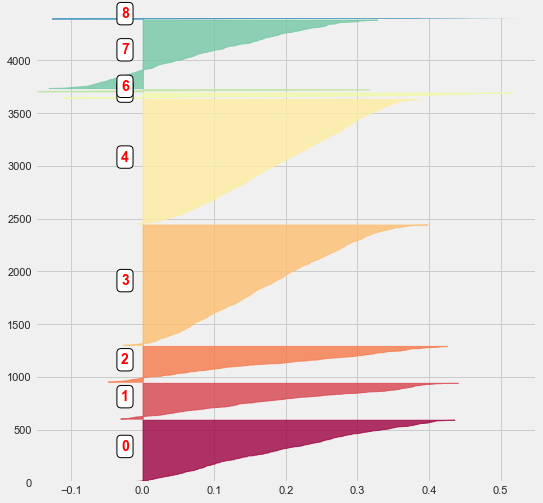

In [219]:
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#____________________________________
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#__________________
# and do the graph
graph_component_silhouette(n_clusters, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, clusters_clients)

** c/ _Customers morphotype_**

At this stage, I have verified that the different clusters are reasonably disjoint (at least, in a global way). It remains to understand the behavior of the customers in each cluster. To do so, I start by adding to the `selected_customers` dataframe a variable that defines the cluster to which each client belongs:

In [220]:
selected_customers.loc[:, 'cluster'] = clusters_clients

Then, I average the contents of this dataframe by first selecting the different groups of clients. This gives access to, for example, the average baskets price, the number of visits or the total sums spent by the clients of the different clusters. I also determine the number of clients in each group (variable ** size **):

In [221]:
merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])
#_____________________________________________________
merged_df.drop('CustomerID', axis = 1, inplace = True)
print('number of customers:', merged_df['size'].sum())

merged_df = merged_df.sort_values('sum')

number of customers: 4324


Finally, I re-organize the content of the dataframe by ordering the different clusters: first, in relation to the amount wpsent in each product category and then, according to the total amount spent:

In [222]:
liste_index = []
focused_cols=['categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4', 
              'canceled%', 'unique_prod','sum']
for col in focused_cols:
    idx=merged_df[col].idxmax()
    if idx not in liste_index:
        liste_index.append(idx)
liste_index_reordered = liste_index.copy()
liste_index_reordered += [ s for s in merged_df.index if s not in liste_index]
merged_df = merged_df.reindex(index = liste_index_reordered)
merged_df = merged_df.reset_index(drop = False)
merged_df['cluster']=merged_df['cluster'].astype(int)
merged_df

cluster      count          min           max         mean           sum    categ_0    categ_1    categ_2    categ_3    categ_4  canceled%  unique_prod  LastPurchase  FirstPurchase  size
0        0   2.232877   215.895000    323.300942   266.071928    580.507671  62.698765   9.552590   7.172264  12.863541   7.712840   1.334012    23.032534    141.619863     221.214041   584
1        1   2.302941   197.797118    324.997529   252.515473    597.857618  24.609684  51.329899   5.319760  12.034808   6.705850   0.589144    30.902941    103.435294     186.400000   340
2        7   2.015385   265.856431    366.635892   312.203355    594.748908  22.324753   8.357661  34.372829  16.366949  18.577808   1.518353    28.538462    224.793846     284.546154   650
3        2   2.635294   235.094559    426.560676   325.614806    922.942206  17.661574   8.140074   5.438104  61.271845   7.488403   0.816975    22.582353    110.917647     219.341176   340
4        3   2.092025   298.655933    455.286117   370.602356    757.557967  28.433350  11.993899  13.728240  19.411147  26.433364   0.930381    43.537248     46.039439      98.896582  1141
5        5   2.938776   132.444490    446.239388   271.903753    996.937551  31.961935  14.013406  15.638326  24.127188  14.259146  65.792148    35.346939    128.612245     257.408163    49
6        6  61.272727    50.250455  10585.610000  2180.135152  84631.040909  28.401407  10.414886  15.589493  28.222479  17.371736   4.343805   584.545455      7.454545     352.454545    22
7        4   8.529611   161.156997    778.119992   408.103579   3490.287640  30.895739  13.182830  14.804309  23.079788  18.037334   1.435248   128.486464     30.993232     318.325719  1182
8        8   1.312500  4169.561875   5796.270625  4917.752708   6800.960625  30.628799  15.806489  15.835506  22.373679  15.355527   5.214049    75.812500    123.625000     147.937500    16

** d / _Customers morphology_ **

Finally, I created a representation of the different morphotypes. To do this, I define a class to create "Radar Charts" (which has been adapted from this [kernel](https://www.kaggle.com/yassineghouzam/don-t-know-why-employees-leave -read-this)):

In [223]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):

        angles = np.arange(0, 360, 360./len(variables))

        ix, iy = location[:] ; size_x, size_y = sizes[:]
        
        axes = [fig.add_axes([ix, iy, size_x, size_y], polar = True, 
        label = "axes{}".format(i)) for i in range(len(variables))]

        _, text = axes[0].set_thetagrids(angles, labels = variables)
        
        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)
        
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")
        
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            grid_label = [""]+["{:.0f}".format(x) for x in grid[1:-1]]
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])
        
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
                
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)
        
    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)


This allows to have a global view of the content of each cluster:

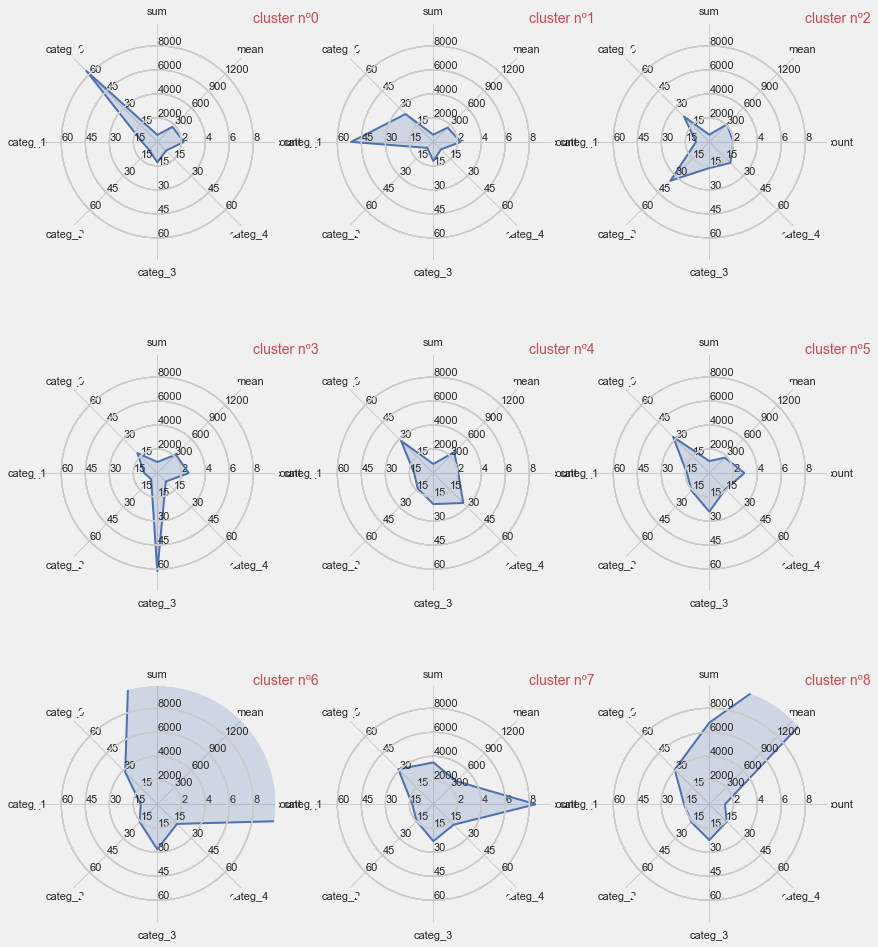

In [224]:
fig = plt.figure(figsize=(10,12))

attributes = ['count', 'mean', 'sum', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
ranges = [[0.01, 10], [0.01, 1500], [0.01, 10000], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75]]
index  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

n_groups = n_clusters ; i_cols = 3
i_rows = n_groups//i_cols
size_x, size_y = (1/i_cols), (1/i_rows)

for ind in range(n_clusters):
    ix = ind%3 ; iy = i_rows - ind//3
    pos_x = ix*(size_x + 0.05) ; pos_y = iy*(size_y + 0.05)            
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y] 
    #______________________________________________________
    data = np.array(merged_df.loc[index[ind], attributes])    
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color = 'b', linewidth=2.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = 'cluster nº{}'.format(index[ind]), color = 'r')
    ind += 1 

- NOTE: Values for categ_0 - categ_4 are percentages not dollar values

- e.g. For **cluster 0** the value for categ_0 is 60, that means that 60% of the purchases that customers from cluster 0 made are coming from **product category 0**

In [229]:
# As a reminder let's see how many customers we have in each cluster

pd.Series(clusters_clients).value_counts()

4    1182
3    1141
7     650
0     584
2     340
1     340
5      49
6      22
8      16
dtype: int64

#### Radar Chart Analysis - Clusters 5,6, and 8

We already said that we have 2 options for clusters 5,6 and 8, either join them to another similar cluster or just keep them. 

Let's quickly analyze each of them

- Cluster 5, 49 customers: It seems that the most similar is **cluster 4**, which is the biggest cluster with 1182 customers.

    - Similarities:
        - Most purchases are made in product category 0, about 30%.
        - Sum of purchases is quite similar
    - Differences:
        - Cluster 4 made more purchases in category 4, about ~30%, vs Cluster 5, about ~15%.
        - Cluster 5 count(number of purchases) and mean(average spending) is slightly higher than Cluster 4.
        
        
- Cluster 6, 22 customers: The best customers, but it's only 22 of them. Anyway, I would recommend keeping this clusters because these are the most important customers who buy frequently and spend a lot of money.

- Cluster 8, 16 customers: This cluster have a potential to become like cluster 6. The key difference is that this cluster have a very low count(number of purchases). They spend a lot money, so if we are able to engage them to buy more frequently, they can become some of the most valuable customers.

# 5 - RFM (recency, frequency, monetary value) analysis

## This RFM analysis will have 2 parts:

1. RFM on CustomerID level, so we have RFM score for each customer

2. RFM on Customer Cluster level so we have RFM score for each cluster

In [381]:
transactions_per_user

CustomerID  count      min      max         mean      sum    categ_0  \
0         12347      7   224.82  1294.32   615.714286  4310.00  26.375870   
1         12348      4   187.44   652.80   359.310000  1437.24  52.461663   
2         12349      1  1457.55  1457.55  1457.550000  1457.55  31.961854   
3         12350      1   294.40   294.40   294.400000   294.40  55.027174   
4         12352      6   104.35   296.50   210.901667  1265.41  29.609376   
...         ...    ...      ...      ...          ...      ...        ...   
4319      18280      1   180.60   180.60   180.600000   180.60   0.000000   
4320      18281      1    80.82    80.82    80.820000    80.82  20.415739   
4321      18282      2    77.84    98.76    88.300000   176.60  12.995470   
4322      18283     16     1.95   307.05   127.473750  2039.58  33.633395   
4323      18287      3    70.68  1001.32   612.426667  1837.28  52.922799   

        categ_1    categ_2    categ_3    categ_4  canceled%  unique_prod  \
0     20.805104  29.540371  11.237123  12.041531   0.000000          103   
1      0.000000   0.000000  47.538337   0.000000   0.000000           21   
2     14.765874  12.918939   5.442009  34.911324   0.000000           72   
3     31.691576   0.000000  13.281250   0.000000   0.000000           16   
4      7.675773  27.528627   2.449799  32.736425   9.509171           57   
...         ...        ...        ...        ...        ...          ...   
4319  41.140642  24.833887   0.000000  34.025471   0.000000           10   
4320  18.930958   0.000000  18.708241  41.945063   0.000000            7   
4321  20.045300  24.405436  13.674972  28.878822   0.821065           12   
4322  41.693388   5.631061  16.355328   2.686828   0.000000          271   
4323  25.077288   2.558129  17.591222   1.850562   0.000000           59   

      LastPurchase  FirstPurchase  
0                2            367  
1               75            358  
2               18             18  
3              310            310  
4               36            296  
...            ...            ...  
4319           277            277  
4320           180            180  
4321             7            126  
4322             3            337  
4323            42            201  

[4324 rows x 15 columns]

### 5.1 RFM on CustomerID level

#### For RFM analysis we will need

- CustomerID
- Last Purchase (min recency)
- First Purchase (max recency)
- count (frequency)
- sum (monetary value)



In [230]:
rmf = transactions_per_user[['CustomerID', 'LastPurchase', 'FirstPurchase', 'count', 'sum']]

In [231]:
rmf.head()

CustomerID  LastPurchase  FirstPurchase  count      sum
0      12347             2            367      7  4310.00
1      12348            75            358      4  1437.24
2      12349            18             18      1  1457.55
3      12350           310            310      1   294.40
4      12352            36            296      6  1265.41

#### Key idea is to have 1-4  score for each customerID when it comes to Recency, Frequency and Monetary value.

- NOTE that 1 represent the best score and 4 the worst

In [232]:
quantiles = rmf.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [233]:
segmented_rfm = rmf

In [234]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [235]:
segmented_rfm['r_quartile'] = segmented_rfm['LastPurchase'].apply(RScore, args=('LastPurchase',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['count'].apply(FMScore, args=('count',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['sum'].apply(FMScore, args=('sum',quantiles,))
segmented_rfm.head()

CustomerID  LastPurchase  FirstPurchase  count      sum  r_quartile  f_quartile  m_quartile
0      12347             2            367      7  4310.00           1           1           1
1      12348            75            358      4  1437.24           3           2           2
2      12349            18             18      1  1457.55           2           4           2
3      12350           310            310      1   294.40           4           4           4
4      12352            36            296      6  1265.41           2           1           2

#### Now that we have individual values for RFM, let's group them together in RFMScore column

In [236]:
segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str) + segmented_rfm.f_quartile.map(str) + segmented_rfm.m_quartile.map(str)
segmented_rfm.head()

CustomerID  LastPurchase  FirstPurchase  count      sum  r_quartile  f_quartile  m_quartile RFMScore
0      12347             2            367      7  4310.00           1           1           1      111
1      12348            75            358      4  1437.24           3           2           2      322
2      12349            18             18      1  1457.55           2           4           2      242
3      12350           310            310      1   294.40           4           4           4      444
4      12352            36            296      6  1265.41           2           1           2      212

#### Let's see who are the customers with 111 score. That's the best RFM score or in other words that's our best customers. They bought recently, buy frequently, and spend the most.

In [237]:
segmented_rfm[segmented_rfm['RFMScore']=='111'].sort_values('sum', ascending=False).head(10)

CustomerID  LastPurchase  FirstPurchase  count        sum  r_quartile  f_quartile  m_quartile RFMScore
1682      14646             1            354     72  278742.02           1           1           1      111
4188      18102             0            367     60  259657.30           1           1           1      111
3717      17450             8            367     45  189575.53           1           1           1      111
1872      14911             1            373    195  128946.06           1           1           1      111
1327      14156             9            371     54  113693.36           1           1           1      111
3760      17511             2            373     30   88293.31           1           1           1      111
3167      16684             4            358     28   65920.12           1           1           1      111
991       13694             3            373     50   63067.14           1           1           1      111
2169      15311             0            373     90   59340.33           1           1           1      111
558       13089             2            369     96   57306.59           1           1           1      111

##### Top 300 customers - what percentage of total revenue they account for?

In [243]:
n1 = segmented_rfm.sort_values('sum', ascending=False).head(300)['sum'].sum()
n2 = segmented_rfm['sum'].sum()

In [245]:
print(f'Top 300 customers accounts for {round((n1 / n2 * 100),2)}% of the revenue')

Top 300 customers accounts for 53.74% of the revenue


### 5.2 RFM on Customer Cluster level

In [246]:
merged_df

cluster      count          min           max         mean           sum    categ_0    categ_1    categ_2    categ_3    categ_4  canceled%  unique_prod  LastPurchase  FirstPurchase  size
0        0   2.232877   215.895000    323.300942   266.071928    580.507671  62.698765   9.552590   7.172264  12.863541   7.712840   1.334012    23.032534    141.619863     221.214041   584
1        1   2.302941   197.797118    324.997529   252.515473    597.857618  24.609684  51.329899   5.319760  12.034808   6.705850   0.589144    30.902941    103.435294     186.400000   340
2        7   2.015385   265.856431    366.635892   312.203355    594.748908  22.324753   8.357661  34.372829  16.366949  18.577808   1.518353    28.538462    224.793846     284.546154   650
3        2   2.635294   235.094559    426.560676   325.614806    922.942206  17.661574   8.140074   5.438104  61.271845   7.488403   0.816975    22.582353    110.917647     219.341176   340
4        3   2.092025   298.655933    455.286117   370.602356    757.557967  28.433350  11.993899  13.728240  19.411147  26.433364   0.930381    43.537248     46.039439      98.896582  1141
5        5   2.938776   132.444490    446.239388   271.903753    996.937551  31.961935  14.013406  15.638326  24.127188  14.259146  65.792148    35.346939    128.612245     257.408163    49
6        6  61.272727    50.250455  10585.610000  2180.135152  84631.040909  28.401407  10.414886  15.589493  28.222479  17.371736   4.343805   584.545455      7.454545     352.454545    22
7        4   8.529611   161.156997    778.119992   408.103579   3490.287640  30.895739  13.182830  14.804309  23.079788  18.037334   1.435248   128.486464     30.993232     318.325719  1182
8        8   1.312500  4169.561875   5796.270625  4917.752708   6800.960625  30.628799  15.806489  15.835506  22.373679  15.355527   5.214049    75.812500    123.625000     147.937500    16

In [247]:
rmf_cust_clusters = merged_df[['cluster', 'LastPurchase', 'FirstPurchase', 'count', 'sum']]

In [248]:
rmf_cust_clusters

cluster  LastPurchase  FirstPurchase      count           sum
0        0    141.619863     221.214041   2.232877    580.507671
1        1    103.435294     186.400000   2.302941    597.857618
2        7    224.793846     284.546154   2.015385    594.748908
3        2    110.917647     219.341176   2.635294    922.942206
4        3     46.039439      98.896582   2.092025    757.557967
5        5    128.612245     257.408163   2.938776    996.937551
6        6      7.454545     352.454545  61.272727  84631.040909
7        4     30.993232     318.325719   8.529611   3490.287640
8        8    123.625000     147.937500   1.312500   6800.960625

In [249]:
segmented_rfm_clusters = rmf_cust_clusters

In [251]:
segmented_rfm_clusters['r_quartile'] = segmented_rfm_clusters['LastPurchase'].apply(RScore, args=('LastPurchase',quantiles,))
segmented_rfm_clusters['f_quartile'] = segmented_rfm_clusters['count'].apply(FMScore, args=('count',quantiles,))
segmented_rfm_clusters['m_quartile'] = segmented_rfm_clusters['sum'].apply(FMScore, args=('sum',quantiles,))
segmented_rfm_clusters

cluster  LastPurchase  FirstPurchase      count           sum  r_quartile  f_quartile  m_quartile
0        0    141.619863     221.214041   2.232877    580.507671           3           2           3
1        1    103.435294     186.400000   2.302941    597.857618           3           2           3
2        7    224.793846     284.546154   2.015385    594.748908           4           2           3
3        2    110.917647     219.341176   2.635294    922.942206           3           2           2
4        3     46.039439      98.896582   2.092025    757.557967           2           2           2
5        5    128.612245     257.408163   2.938776    996.937551           3           2           2
6        6      7.454545     352.454545  61.272727  84631.040909           1           1           1
7        4     30.993232     318.325719   8.529611   3490.287640           2           1           1
8        8    123.625000     147.937500   1.312500   6800.960625           3           3           1

#### Now that we have individual values for RFM, let's group them together in RFMScore column

In [252]:
segmented_rfm_clusters['RFMScore'] = segmented_rfm_clusters.r_quartile.map(str) + segmented_rfm_clusters.f_quartile.map(str) + segmented_rfm_clusters.m_quartile.map(str)
segmented_rfm_clusters

cluster  LastPurchase  FirstPurchase      count           sum  r_quartile  f_quartile  m_quartile RFMScore
0        0    141.619863     221.214041   2.232877    580.507671           3           2           3      323
1        1    103.435294     186.400000   2.302941    597.857618           3           2           3      323
2        7    224.793846     284.546154   2.015385    594.748908           4           2           3      423
3        2    110.917647     219.341176   2.635294    922.942206           3           2           2      322
4        3     46.039439      98.896582   2.092025    757.557967           2           2           2      222
5        5    128.612245     257.408163   2.938776    996.937551           3           2           2      322
6        6      7.454545     352.454545  61.272727  84631.040909           1           1           1      111
7        4     30.993232     318.325719   8.529611   3490.287640           2           1           1      211
8        8    123.625000     147.937500   1.312500   6800.960625           3           3           1      331

# Final remarks - Summary

NOTE: Take a look at .pptx for the summary and more info about this notebook.


### Work Done:
- We developed unique customer segments using RFM (recency, frequency, monetary value) analysis 
    - Additionaly, we assigned RMF score to each customerID, in case that we want to analyze something on the customer level rather than on the cluster level
- Defined 5 product categories
- Examined how unique customer segments spend per product category

### This work enhanced business understanding of the customers/unique cluster and will play an important role in optimizing marketing strategy, increasing revenue & profits, and decreasing customer churn. Moreover, it will help in identifying upselling & cross-selling opportunities.



Acknowledgements:

Kaggle:

[F. Daniel](https://www.kaggle.com/fabiendaniel/customer-segmentation)


[Miljan Stojiljkovic](https://www.kaggle.com/miljan/customer-segmentation)


[J. Abécassis](https://www.kaggle.com/judithabk6) 

_______

USC MSBA students